# Minisom
- 시계열 데이터의 클러스터링 방법에 대해 찾다가 알게 됨
- som = Self Organization map
  - 차원축소와 군집화를 동시에 한다 (공부 필요)
- 성능이 kmeans보다 훨씬 좋다

In [0]:
!pip install minisom

# 라이브러리

In [0]:
#https://github.com/JustGlowing/minisom/blob/master/minisom.py
from minisom import MiniSom

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# 한글 폰트 설치
# https://pinkwink.kr/1255
%config InlineBackend.figure_format = 'retina'
!apt -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()
from matplotlib.gridspec import GridSpec

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


# 24시간 매출 비율에 따른 클러스터링
- **목적:** type_of_business의 결측을 채우기 위해, 혹은 대체하기 위해 실시
- **계기:** 업종별로 주매출 시간이 다르다는 것을 EDA에서 파악하였음, 어느 정도는 분류가 가능하다고 판단
- **방법:** 업종 개수가 35개이므로 처음에는 6*6으로 map size를 정하고 minisom으로 클러스터링. 그리고 map size는 차츰 수정


In [0]:
train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_full_quarter.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
shop_id_hour = train3.groupby('store_id').mean().loc[:,'main_h_0':'main_h_23'] # 각 상점의 24시간 컬럼만 추출

In [0]:
shop_id_hour.head()

,main_h_0,main_h_1,main_h_2,main_h_3,main_h_4,main_h_5,main_h_6,main_h_7,main_h_8,main_h_9,main_h_10,main_h_11,main_h_12,main_h_13,main_h_14,main_h_15,main_h_16,main_h_17,main_h_18,main_h_19,main_h_20,main_h_21,main_h_22,main_h_23
store_id,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000446,0.039500,0.065387,0.083687,0.079893,0.081678,0.097969,0.099085,0.115822,0.124303,0.123410,0.066057,0.020085,0.002232,0.000446
1,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.001322,0.020095,0.115283,0.196721,0.203067,0.179270,0.131412,0.083025,0.062930,0.006610,0.000264,0.000000,0.000000,0.000000
2,0.000000,0.003425,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.008562,0.003425,0.025685,0.113014,0.159247,0.190068,0.184932,0.142123,0.130137,0.037671,0.000000,0.000000,0.001712
4,0.002058,0.000172,0.000343,0.000172,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000172,0.037564,0.076672,0.083705,0.052487,0.061921,0.108233,0.174443,0.180274,0.134134,0.056261,0.021955,0.009434
5,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000511,0.004086,0.024004,0.062308,0.102145,0.118488,0.148110,0.149132,0.148110,0.168029,0.065884,0.008172,0.001021,0.000000


# 학습

In [0]:
data = shop_id_hour.values
# Minisim(x, y, input_len, sigma, , ,)
# x: x dimension of the SOM.
# x: y dimension of the SOM. ==> x*y = 클러스터링 개수
# input_len: Number of the elements of the vectors in input.
# sigma: Spread of the neighborhood function, needs to be adequate to the dimensions of the map.
#       (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
#       - 1 이상 x & y 이하
#       - 클러스터 중심 계산에 쓰임

som = MiniSom(4, 3, data.shape[1], sigma=2., learning_rate=0.1, 
              neighborhood_function='gaussian', random_seed=10)
som.pca_weights_init(data)
print("Training...")
som.train_batch(data, 50000, verbose=True)  # random training
print("\n...ready!")
# quantization error: the average distance between each input sample and its best matching unit.
# topographic error: finding the best-matching and second-best-matching neuron in the map for each input and then evaluating the positions

Training...
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.0009913876609086558
 topographic error: 0.002541942043721403

...ready!


# minisom 결과 시각화

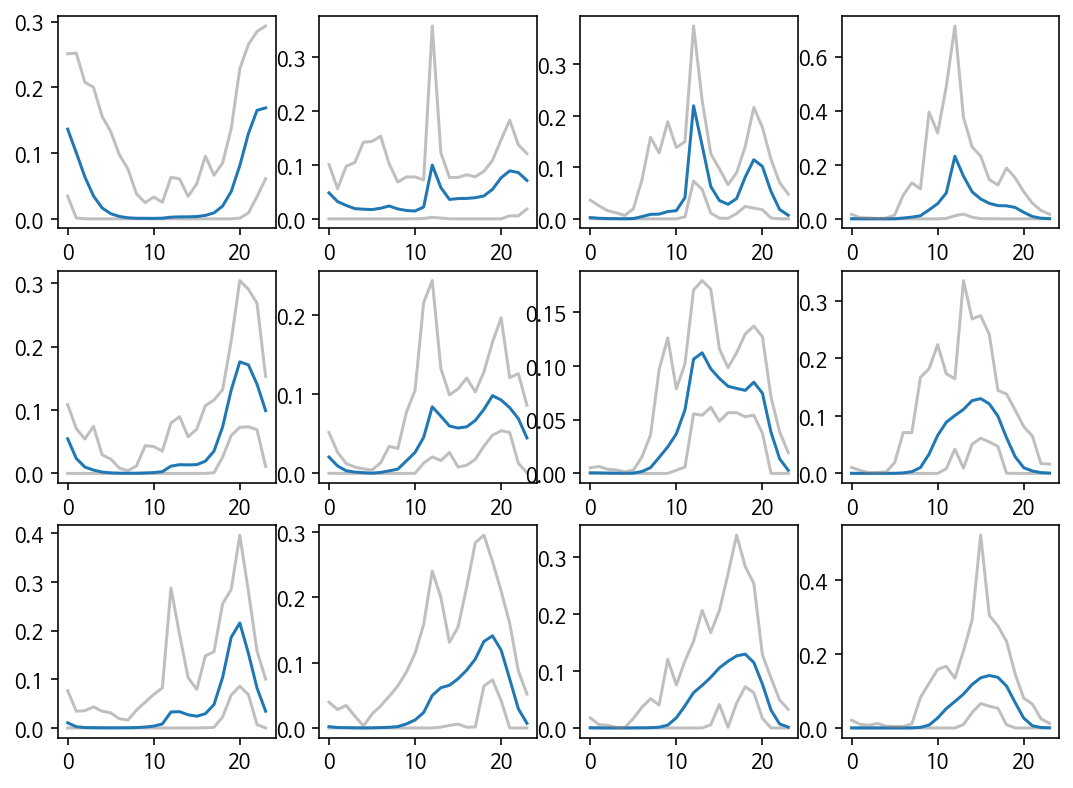

In [0]:
win_map = som.win_map(data)

plt.figure(figsize=(16, 16))
the_grid = GridSpec(7, 7)
for position in win_map.keys():
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
plt.show()

- 유사한 시계열끼리 묶인 것을 확인할 수 있다. 

# 업종과 클러스터링 결과 비교

In [0]:
# 클러스터링 결과를 변수로 추가
clt_label = []
for i in range(1967):
  label = som.winner(data[i])
  clt_label.append(label)

shop_id_hour['clt'] = clt_label
clt = shop_id_hour.reset_index()[['store_id','clt']]
train3 = pd.merge(train3,clt, on='store_id')

In [0]:
train3.groupby(['clt','region2','type_of_business3']).mean()[['amount']].head(10)

amount
clt    region2 type_of_business3              
(0, 0) 강원      음식점업               8.216328e+06
       경기      소매업                5.124193e+06
               운영업                2.832713e+06
               음식업점               3.558445e+06
               음식점업               3.933673e+06
               학원                 9.721925e+06
       경남      음식점업               4.498632e+06
               학원                 9.705208e+06
       경북      음식점업               2.990391e+06
       대전      음식점업               1.243355e+06

Text(0.5, 1, '업종과 클러스터링별 Store 개수')

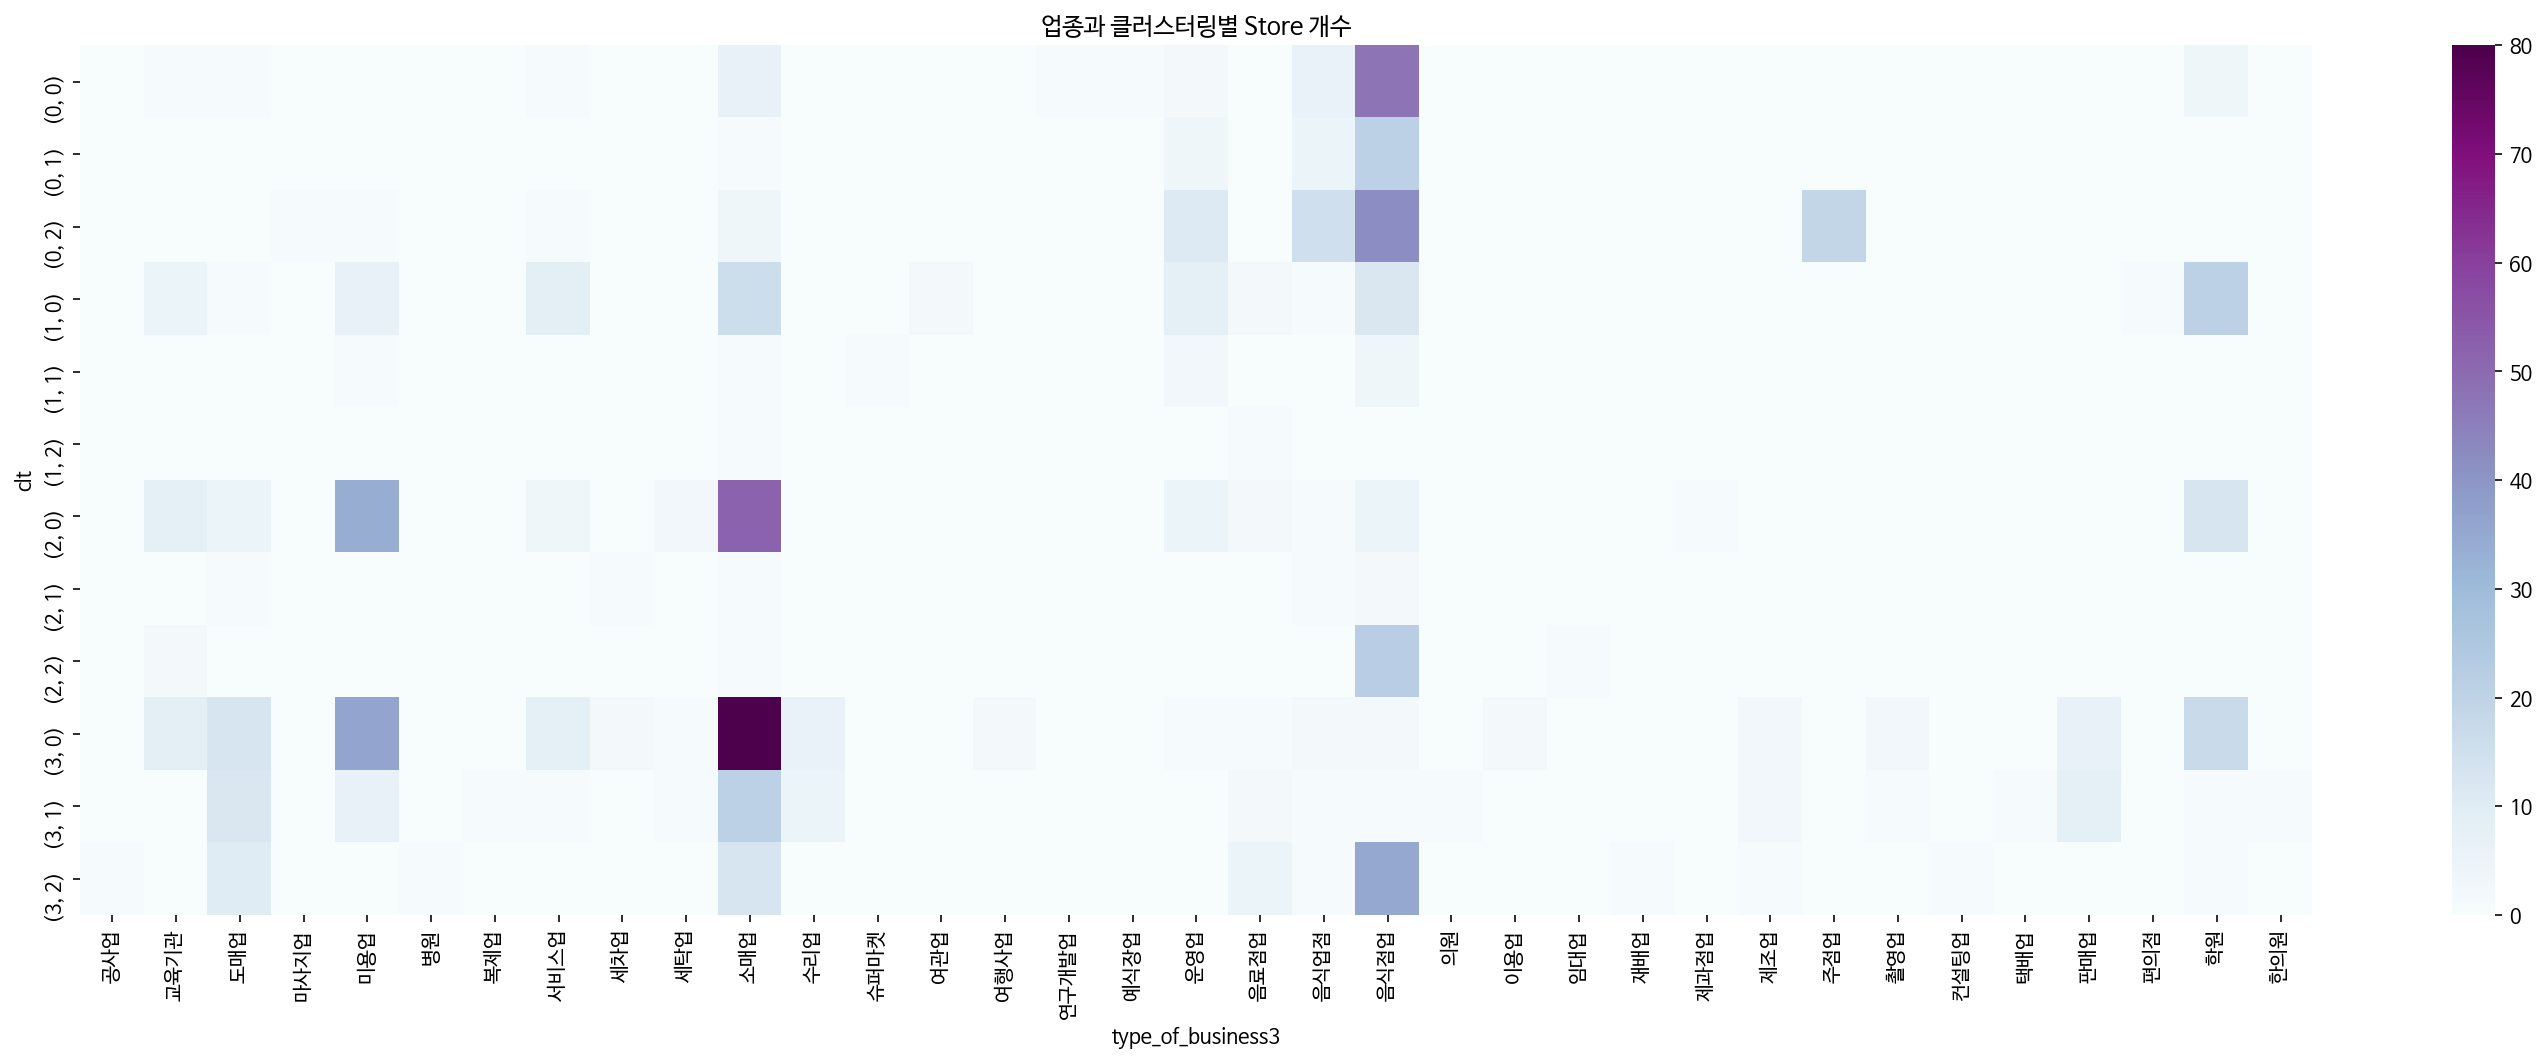

In [0]:
plt.figure(figsize=(25,8))
sns.heatmap(pd.crosstab(train3[['store_id','clt','type_of_business3']].drop_duplicates()['clt'],train3[['store_id','clt','type_of_business3']].drop_duplicates()['type_of_business3']), cmap='BuPu')
plt.title('업종과 클러스터링별 Store 개수')

Text(0.5, 1, '업종과 클러스터링별 Amount 평균')

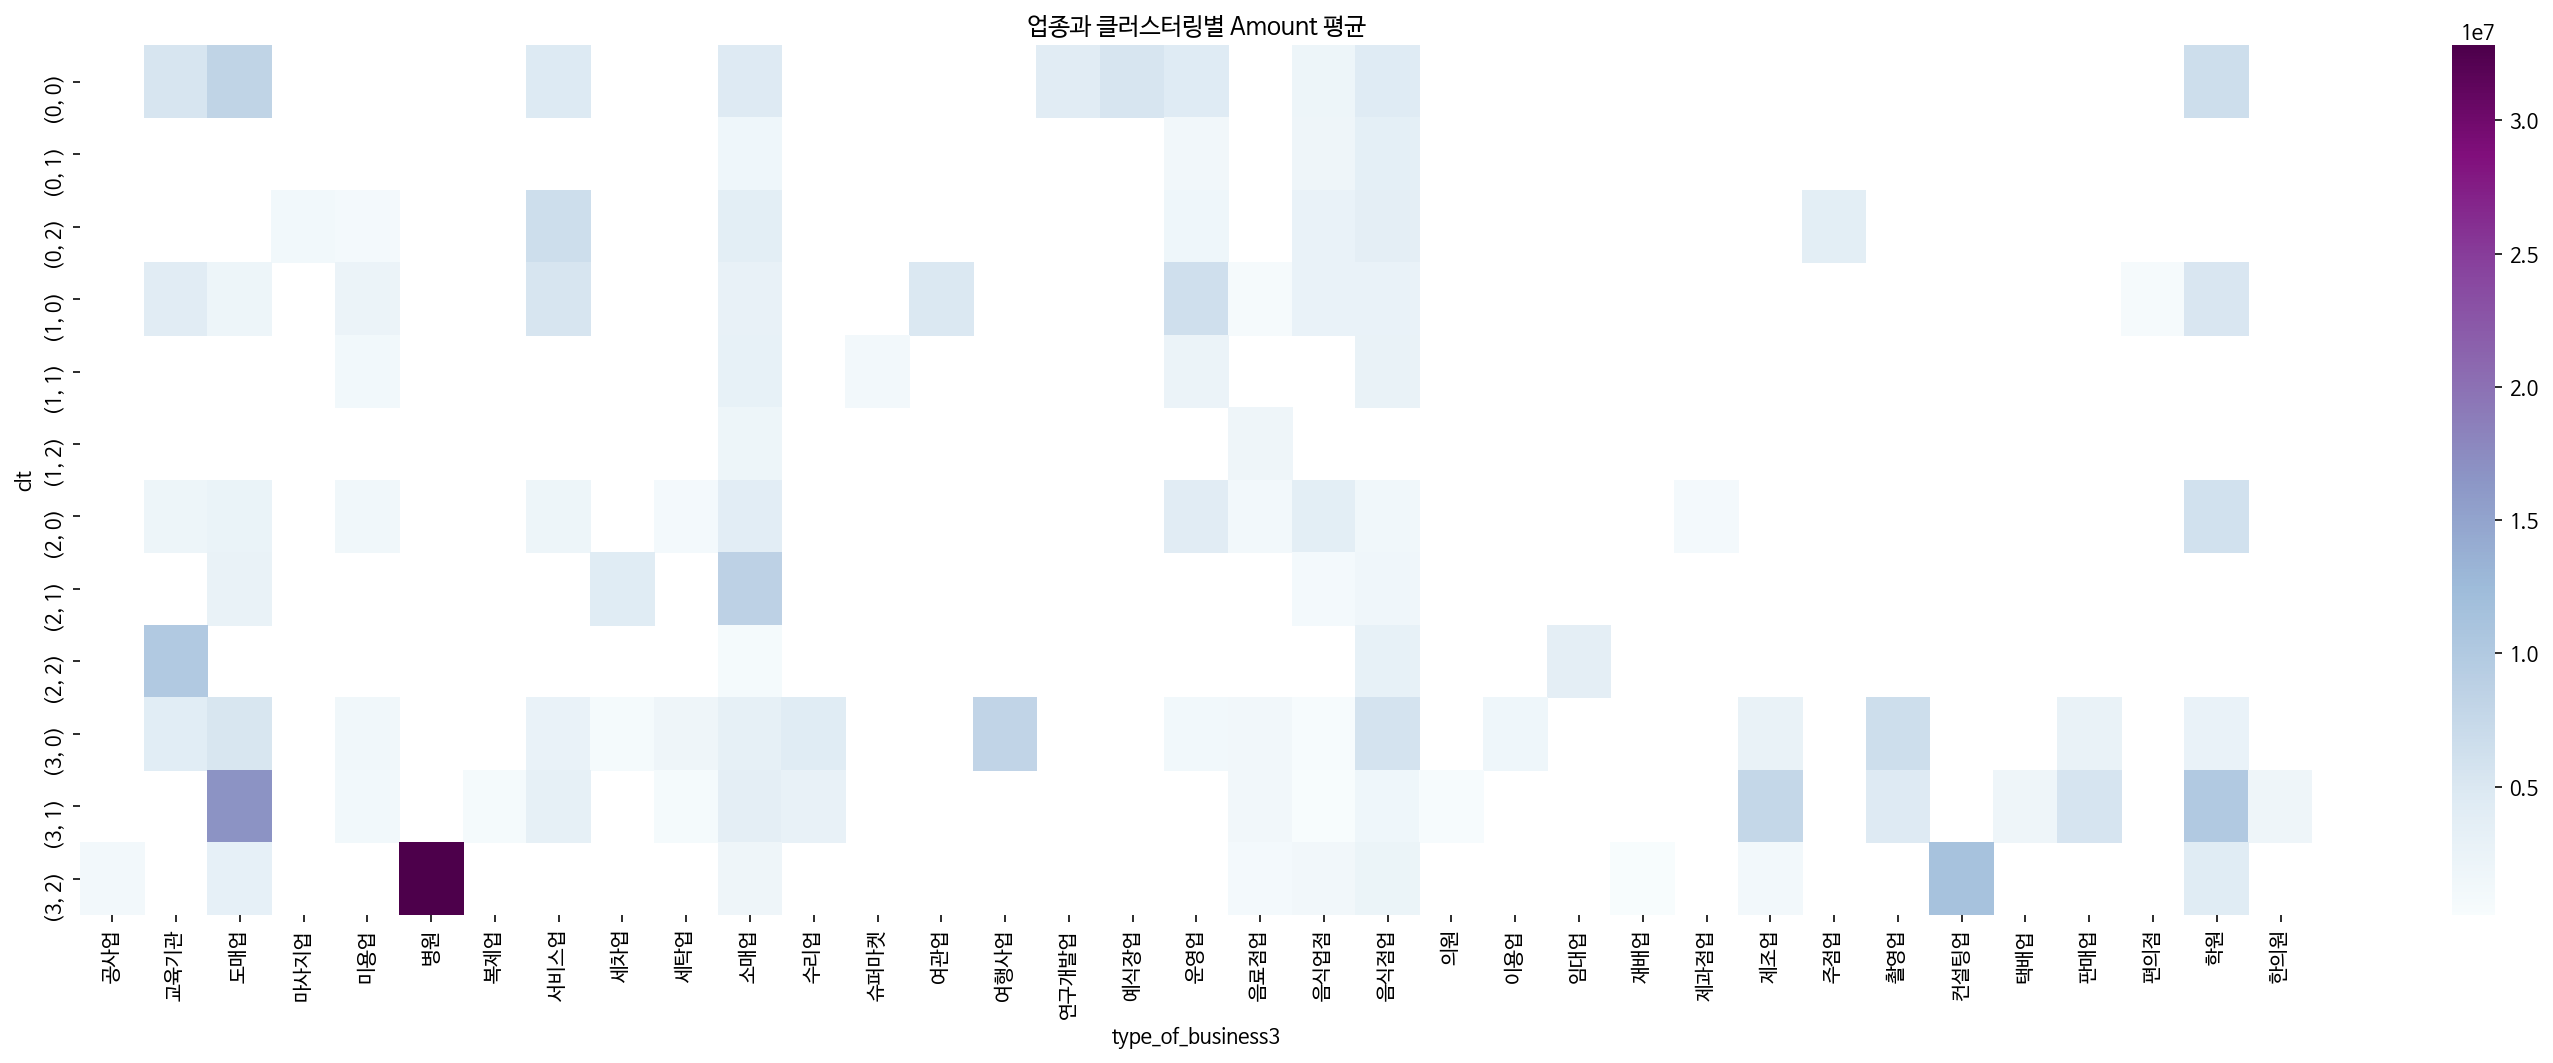

In [0]:
plt.figure(figsize=(25,8))
sns.heatmap(pd.pivot_table(data=train3, index='clt',columns='type_of_business3', values='amount',aggfunc='mean'), cmap='BuPu')
plt.title('업종과 클러스터링별 Amount 평균')

- 시간별 매출 비율로 클러스터링을 했기 때문에 업종별로 잘 묶이진 않았다.
- 하지만 저녁 매출 비중이 높을 '주점업'이 저녁 매출 비율이 높은 그룹인 (0,2)에 속하는 것을 볼 수 있다. 

Text(0.5, 1.0, 'Amount of store grouped by clt')

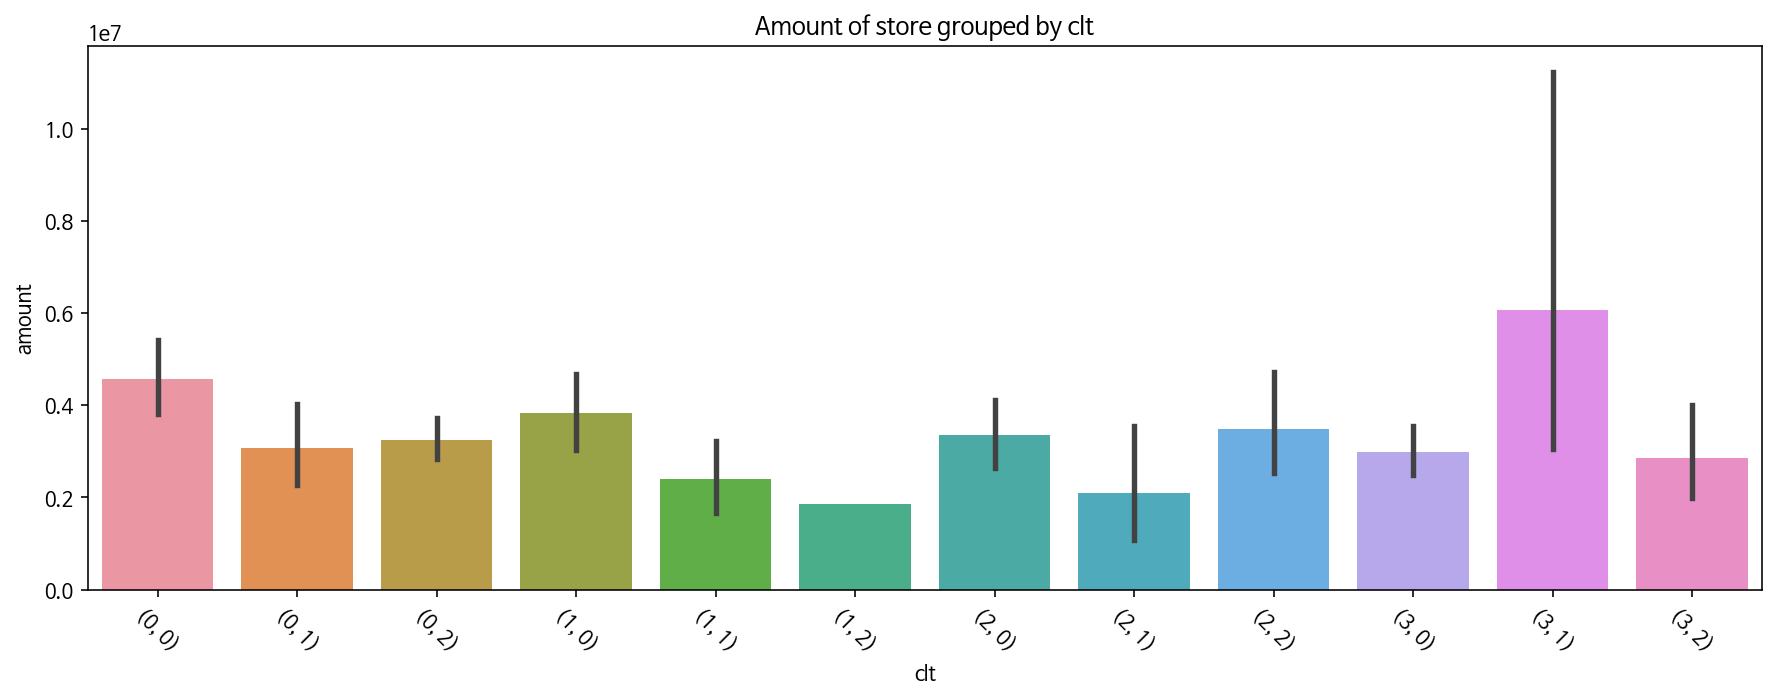

In [0]:
plt.figure(figsize=(15,5))
#sns.boxenplot(x='clt',y='amount', data=train3.groupby(['clt','region','region2','type_of_business3']).mean()[['amount']].reset_index(), scale='linear')
sns.barplot(x='clt',y='amount', data=train3.groupby(['clt','region','region2','type_of_business3']).mean()[['amount']].reset_index(), )

plt.xticks(rotation=-45)
plt.title('Amount of store grouped by clt')

- 군집간의 amount 평균 및 범위가 달라서 Amount 예측에는 어느정도 도움이 될 듯

Text(0.5, 1.0, 'Amount of store grouped by type_of_business3')

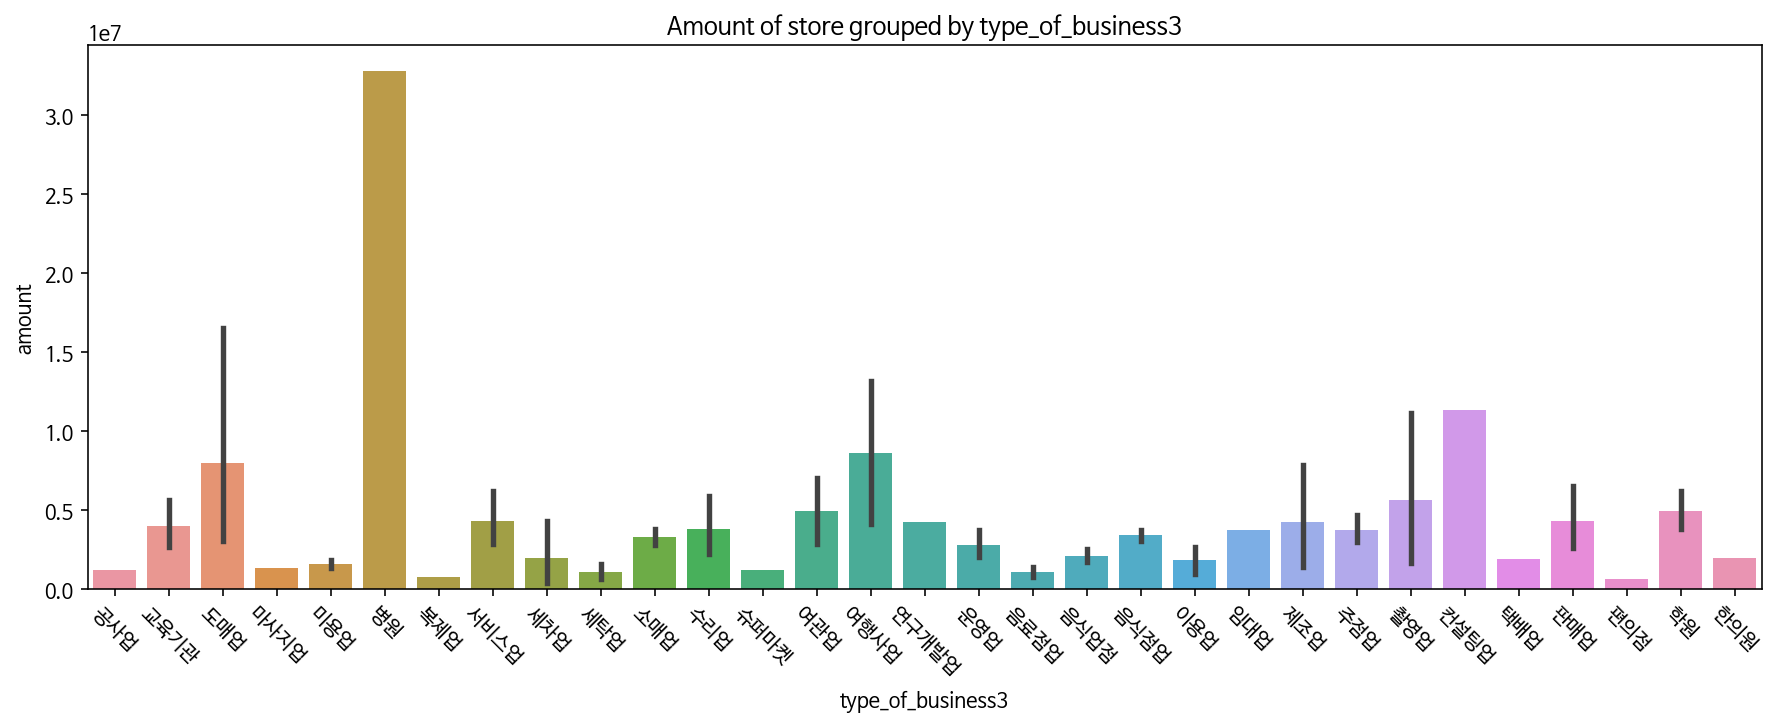

In [0]:
import seaborn as sns
plt.figure(figsize=(15,5))
sns.barplot(x='type_of_business3',y='amount', data=train3.groupby(['type_of_business3','region','region2','clt']).mean()[['amount']].reset_index())
plt.xticks(rotation=-45)
plt.title('Amount of store grouped by type_of_business3')

# 결론
- **Minisum**: minisom의 성능은 아주 좋다.
- **업종 결측치 커버**: 업종과 클러스터링 결과의 일치율은 애매하다.
- **모델링**: 클러스터링 결과가 amount 예측에 도움이 될 것 같다. 물론 넣어봐야 알겠지만